# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [200]:
# Import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand, countDistinct,count, trim, desc
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.functions import sum as fsum
from pyspark.sql.types import IntegerType, FloatType,StringType

import pyspark.sql.functions as f

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.feature import StandardScaler, VectorAssembler,Normalizer, MinMaxScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [201]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [202]:
# Read json data
sparkify_data = 'mini_sparkify_event_data.json'
#sparkify_data = 'C:/Users/Peter/Desktop/DSNano/Term 6/mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)

In [203]:
# Print Schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [204]:
# Overview of data
df_spark = pd.DataFrame(df.take(5), columns=df.columns)
df_spark.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [205]:
df.describe("artist", "sessionId").show()

+-------+------------------+-----------------+
|summary|            artist|        sessionId|
+-------+------------------+-----------------+
|  count|            228108|           286500|
|   mean| 551.0852017937219|1041.526554973822|
| stddev|1217.7693079161374|726.7762634630741|
|    min|               !!!|                1|
|    max| ÃÂlafur Arnalds|             2474|
+-------+------------------+-----------------+



In [206]:
# Select and show statistcs for several items 
for col in df.schema:    
    if str(col.name) in ['artist','auth','gender','itemInSession','level' ,'location','method','page','status']:
        df.groupBy(str(col.name)).count().show() # Understand the meaning of columns

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|      The Black Keys| 1125|
|         Silverstein|   60|
|           Kate Nash|   99|
|        Yann Tiersen|  139|
|    Jane's Addiction|   68|
|          Tim Hughes|   39|
|          Carl Craig|    3|
|Dashboard Confess...|   98|
|Yonder Mountain S...|   63|
|           Los Lobos|   45|
|Pete Rock & C.L. ...|    2|
|        Ziggy Marley|   28|
|      Jarabe De Palo|   83|
|               Rufio|   13|
|WC And The Maad C...|    1|
|      Jorge Gonzalez|   24|
|                Silk|   22|
|  The Watts Prophets|    6|
|            La Shica|    2|
|        Generation X|   19|
+--------------------+-----+
only showing top 20 rows

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+

+------+------+
|gender| count|
+------+------+
|     F|154578|
|  null|  8346|
|     M|123576|
+------+------+

+---

In [207]:
# Check for null values 
for i in df.columns:
    print(i, ':', df.filter(df[i].isNull()).count())

artist : 58392
auth : 0
firstName : 8346
gender : 8346
itemInSession : 0
lastName : 8346
length : 58392
level : 0
location : 8346
method : 0
page : 0
registration : 8346
sessionId : 0
song : 58392
status : 0
ts : 0
userAgent : 8346
userId : 0


In [208]:
# Total number of sessions
print('Total activity records: ', df.count())

Total activity records:  286500


In [209]:
# Total sessions after removing duplicates based on user and session id
df_valid = df.dropna(how = "any", subset = ["userId", "sessionId"])
df_valid.count()

286500

In [210]:
# Total number of sessions after removing blank user id 
df_valid = df_valid.filter(df_valid["userId"] != "")
df_valid.count()

278154

In [211]:
# Number of unique users in dataset
user_ids = df_valid.select('userId').dropDuplicates().count()
user_ids

225

In [212]:
# Number of unique session ids
session_ids = df_valid.select('sessionId').dropDuplicates().count()
session_ids

2312

In [213]:
# Number of unique pages
pages = df_valid.select('page').dropDuplicates().count()
pages

19

In [214]:
# Create a user defined function for formating the timestamp
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).hour)

In [215]:
# Apply the udf on the ts column
df = df.withColumn("hour", get_hour(df.ts))
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='20')

In [216]:
# Drop duplicates in page
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [217]:
df_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|     Kael|     M|           47|    Baker|  null| paid|Kingsport-Bristol...|   PUT|Submit Downgrade|1533102330000|      249|null|   307|1538393619000|"Mozilla/5.0 (Mac...|   131|
|  null|Logged In|   Calvin|     M|           17| Marshall|  null| paid|      Pittsburgh, PA|   PUT|Submit Downgrade|1537120757000|      313|null|   307|1538516445000|"Mozilla/5.0 (Mac...|    38|
|  null|Logged In|  

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [218]:
# Churn Definition (1 = cancel, 0 = paid)
churn_def = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# Apply to the dataframe
df = df.withColumn("churn", churn_def("page"))
# Define window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# Applying the window
df = df.withColumn("churn", fsum("churn").over(windowval))

In [219]:
df_pandas = df.toPandas()

In [220]:
df_pandas.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,hour,churn
0,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1.538016e+12,31,Captain Tyin Knots VS Mr Walkway (No Way),200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,8,0
1,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1.538016e+12,31,Beautiful_ Beautiful (Album),200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,9,0
2,Brutha,Logged In,Darianna,F,2,Carpenter,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1.538016e+12,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,9,0
3,None,Logged In,Darianna,F,3,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,Thumbs Up,1.538016e+12,31,None,307,1539003933000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,9,0
4,Josh Ritter,Logged In,Darianna,F,4,Carpenter,316.23791,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1.538016e+12,31,Folk Bloodbath,200,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,9,0


In [221]:
# Count number of songs played in hour
songs_in_hour = df.filter(df.page == "NextSong").groupby(df.hour).count().orderBy(df.hour.cast("float"))
# Create pandas for songs played in hour
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd

,hour,count
0,0,8142
1,1,8154
2,2,8043
3,3,8184
4,4,8360
5,5,8560
6,6,8695
7,7,9214
8,8,9512
9,9,10023


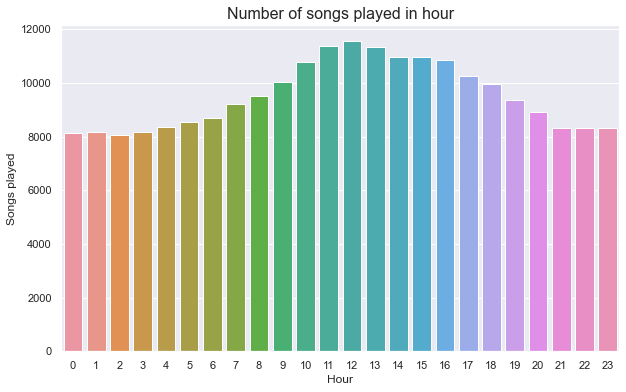

In [222]:
# Songs played in hour
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 6))
plt.title("Number of songs played in hour", fontsize= 16)
sns.barplot(x="hour", y="count", data= songs_in_hour_pd)
plt.xlabel("Hour")
plt.ylabel("Songs played");

In [223]:
# Distribution of users by Churn Type
churn_count = df.groupBy("Churn").agg(countDistinct("userId").alias("Users"))
churn_count_pd = churn_count.toPandas() # Create churn count pd

Text(0, 0.5, 'Number of Users')

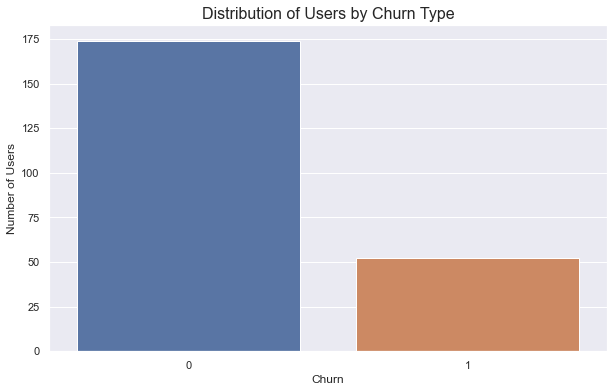

In [224]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 6))
plt.title("Distribution of Users by Churn Type", fontsize= 16)
sns.barplot(x='Churn', y='Users', data= churn_count_pd)
plt.xlabel("Churn")
plt.ylabel("Number of Users")

In [225]:
# Churn per gender
print('Churner per gender')
df.filter(df.page == 'Cancellation Confirmation').select(['userId', 'gender']).drop_duplicates().groupby('gender').count().show()

print('Non-churner per gender')
df.filter(df.page != 'Cancellation Confirmation').select(['userId', 'gender']).drop_duplicates().groupby('gender').count().show()

Churner per gender
+------+-----+
|gender|count|
+------+-----+
|     F|   20|
|     M|   32|
+------+-----+

Non-churner per gender
+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|  null|    1|
|     M|  121|
+------+-----+



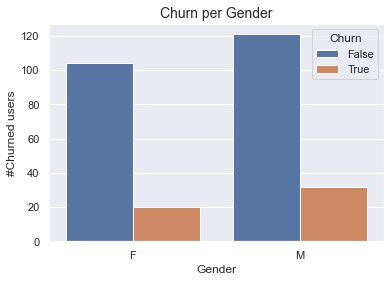

In [226]:
# Churn per gender plot
churn_gender_pd = df.filter(df.page == 'Cancellation Confirmation').select(['userId', 'gender']).drop_duplicates().groupby('gender').count().toPandas()
churn_gender_pd['Churn'] = True
nonchurn_gender_pd = df.filter(df.page != 'Cancellation Confirmation').select(['userId', 'gender']).drop_duplicates().groupby('gender').count().toPandas()
nonchurn_gender_pd['Churn'] = False
churn_gender = pd.concat([churn_gender_pd,nonchurn_gender_pd], sort=False, ignore_index=True)

# Plot
sns.barplot(x='gender', y='count', hue='Churn', data=churn_gender)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('#Churned users', fontsize=12)
plt.title('Churn per Gender', fontsize=14)
plt.show()

In [227]:
# All user activity types
pages = df.groupby('page','method').count().sort('method')
pages.show()

+--------------------+------+-----+
|                page|method|count|
+--------------------+------+-----+
|               About|   GET|  924|
|                Help|   GET| 1726|
|           Downgrade|   GET| 2055|
|            Register|   GET|   18|
|             Upgrade|   GET|  499|
|               Error|   GET|  258|
|Cancellation Conf...|   GET|   52|
|            Settings|   GET| 1514|
|                Home|   GET|14457|
|         Roll Advert|   GET| 3933|
|          Add Friend|   PUT| 4277|
|              Logout|   PUT| 3226|
|              Cancel|   PUT|   52|
|      Submit Upgrade|   PUT|  159|
|     Add to Playlist|   PUT| 6526|
|    Submit Downgrade|   PUT|   63|
|         Thumbs Down|   PUT| 2546|
|               Login|   PUT| 3241|
|       Save Settings|   PUT|  310|
| Submit Registration|   PUT|    5|
+--------------------+------+-----+
only showing top 20 rows



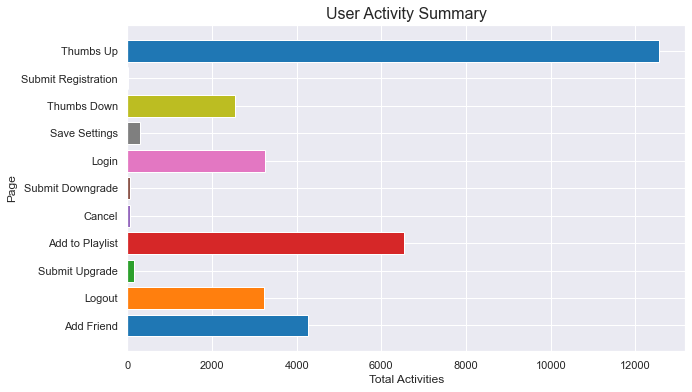

In [228]:
# Use'PUT' to get user proactive activities
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
pages_df = pages.toPandas()
pages_df_plt = pages_df.loc[(pages_df['method'] == 'PUT') & (pages_df['page'] != 'NextSong')]

activity = pages_df_plt['page']
count = pages_df_plt['count']

plt.figure(figsize=(10, 6))
plt.barh(activity, count, color=colors)
plt.ylabel('Page')
plt.xlabel('Total Activities')
plt.title('User Activity Summary', size=16)

plt.show()

In [251]:
#Distribution of users by State
split_col = f.split(df['location'], ',')
df = df.withColumn('City', trim(split_col.getItem(0)))\
        .withColumn('State', trim(split_col.getItem(1)))

In [252]:
#Create a temporary view to perform SQL operations
df.createOrReplaceTempView("df_sqlsparkify")

In [257]:
location_df = spark.sql("""
                           SELECT location, 
                                  Count(DISTINCT userid) AS total_user 
                           FROM   df_sqlsparkify
                           GROUP  BY location 
                           ORDER BY total_user
                           DESC
                           """).toPandas()

In [258]:

location_churn_df = spark.sql("""
                           SELECT location, 
                                  Count(DISTINCT userid) AS churn_user 
                           FROM   df_sqlsparkify
                           WHERE churn=1
                           GROUP BY location
                           """).toPandas()

In [259]:
merge_df = location_churn_df.merge(location_df, on="location").sort_values(by="total_user", ascending=False)

In [260]:
merge_df["percentage"] = merge_df["churn_user"] / merge_df["total_user"] * 100

In [261]:
merge_df.sort_values(by="percentage", ascending=False).head(20)

,location,churn_user,total_user,percentage
38,"Flint, MI",2,2,100.0
18,"Oxnard-Thousand Oaks-Ventura, CA",1,1,100.0
29,"Quincy, IL-MO",1,1,100.0
0,"Cleveland-Elyria, OH",1,1,100.0
20,"Monroe, LA",1,1,100.0
27,"North Wilkesboro, NC",1,1,100.0
23,"Bozeman, MT",1,1,100.0
21,"Little Rock-North Little Rock-Conway, AR",1,1,100.0
17,"Memphis, TN-MS-AR",1,1,100.0
32,"Lexington-Fayette, KY",1,1,100.0


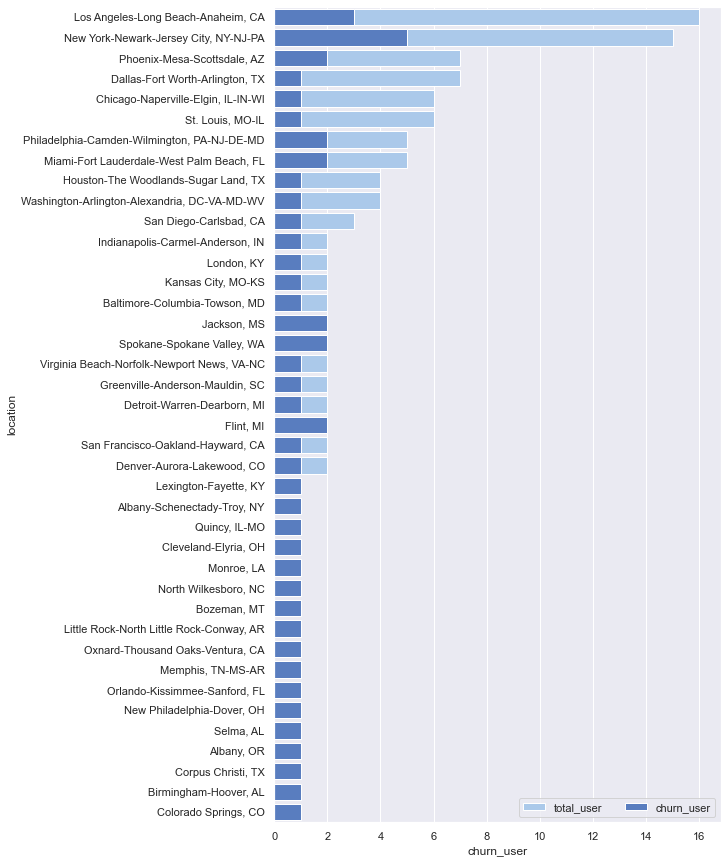

In [263]:
fig, ax = plt.subplots(figsize=(8, 15))
sns.set_color_codes("pastel")
sns.barplot(x="total_user", y="location", data=merge_df, ax=ax,
            label="total_user",color="b")

sns.set_color_codes("muted")
sns.barplot(x="churn_user", y="location", data=merge_df, ax=ax, 
            label="churn_user",color="b")
ax.legend(ncol=2, loc="lower right", frameon=True)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## Numerical Features:
1. Total number of songs 
2. Average length of session
3. Number of songs that received a thumb up
4. Number of songs that received a thumb down
5. Number of friend additions
6. Number of advertisements seen
7. Number of playlist additions
8. Number of unique artists and songs listened to
9. Number of sessions

## Categorial Features:
1. Gender type
2. Browser type
3. OS type
4. Level of the user
5. State a user lives in

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.